# install requirement lib and import

In [41]:
!pip install -r requirements.txt

You should consider upgrading via the '/Users/jirayuwat/Desktop/GAN-indiv-study/env/bin/python3 -m pip install --upgrade pip' command.


In [42]:
import torch 
from torch import nn
import torchvision.datasets as datasets
from torchsummary import summary

import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

import time

# load dataset

- trainset : `X_train, y_train`
    - size `28x28`
    - 60,000 samples
- testset : `X_test, y_test`
    - size `28x28`
    - 10,000 samples

- data range : `0-1` type `float`

In [43]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)


In [44]:
X_train, y_train = mnist_trainset.data / 255,  mnist_trainset.targets
X_train = X_train.reshape(60000,28,28)

X_test, y_test = mnist_testset.data / 255,  mnist_testset.targets

In [45]:
print(f'''\
X_train, y_train shape = {X_train.shape}, {y_train.shape}
X_test, y_test shape = {X_test.shape}, {y_test.shape}

Min of X = {torch.min(X_train)}
Max of X = {torch.max(X_train)}
''')

X_train, y_train shape = torch.Size([60000, 28, 28]), torch.Size([60000])
X_test, y_test shape = torch.Size([10000, 28, 28]), torch.Size([10000])

Min of X = 0.0
Max of X = 1.0



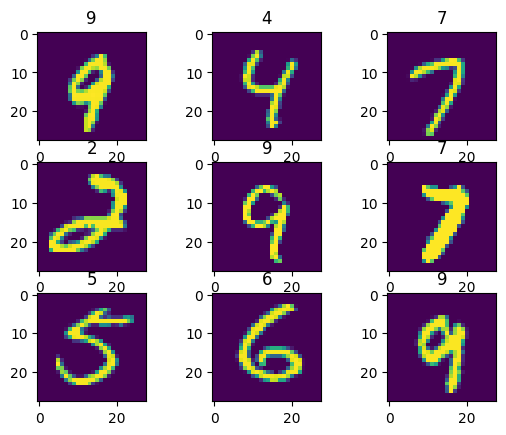

In [46]:
import random
random.seed(42)

for i in range(9):
    plt.subplot(3,3,i+1)
    idx = random.randint(0,60000-1)

    plt.title(y_train[idx].item())
    plt.imshow(X_train[idx])

# Train control

In [47]:
TRAIN_AUTO_ENCODER = False
TRAIN_DCGAN = True

# Auto encoder

In [48]:
class AutoEncoder(nn.Module):

    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(784, 1000),
            nn.ReLU(),
            nn.Linear(1000, latent_dim),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 1000),
            nn.ReLU(),
            nn.Linear(1000, 784),
            nn.Sigmoid()
        )

    def forward(self, x_in):
        x_in = self.encoder(x_in)
        x_in = self.decoder(x_in)

        return x_in.reshape((-1, 1,28,28))

summary(AutoEncoder(10), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1000]         785,000
              ReLU-3                 [-1, 1000]               0
            Linear-4                   [-1, 10]          10,010
              ReLU-5                   [-1, 10]               0
            Linear-6                 [-1, 1000]          11,000
              ReLU-7                 [-1, 1000]               0
            Linear-8                  [-1, 784]         784,784
           Sigmoid-9                  [-1, 784]               0
Total params: 1,590,794
Trainable params: 1,590,794
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 6.07
Estimated Total Size (MB): 6.12
---------------------------------------

In [49]:
ae_model = AutoEncoder(5)

optimizer = torch.optim.Adam(ae_model.parameters(),
                             lr=0.01)

loss_fn = nn.MSELoss()


In [50]:
Loss_hist = []

In [51]:
EPOCHs = 200 if TRAIN_AUTO_ENCODER else 0
prev_loss = float('inf')
for epoch in range(EPOCHs):
    ae_model.train()
    # pred
    y_pred = ae_model(X_train.reshape((-1,1,28,28)).to(torch.float32)).reshape(-1,28, 28)
    
    # zero grad
    optimizer.zero_grad()

    # loss cal
    loss = loss_fn(y_pred, X_train.to(torch.float32))
    Loss_hist.append(loss.item())

    # back-prop
    loss.backward()

    # step
    optimizer.step()

    # print status
    print(f'Epoch {epoch} /{EPOCHs}\t: Loss = {loss.item():.6f}\t,Loss diff = {loss.item() - prev_loss}')
    prev_loss = loss.item()


Text(0.5, 1.0, 'total : 0 epochs')

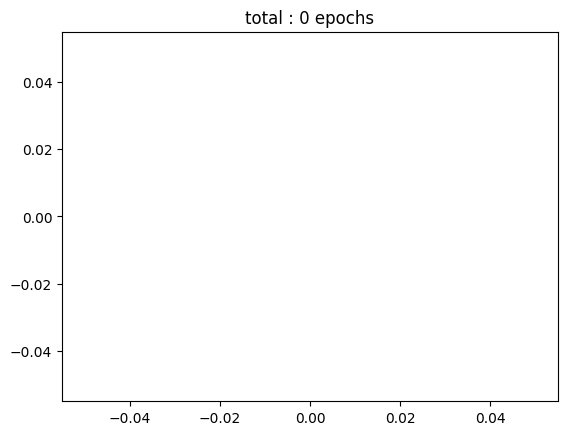

In [52]:
plt.plot(range(len(Loss_hist)),Loss_hist)
plt.title('total : ' + str(len(Loss_hist)) + ' epochs' )

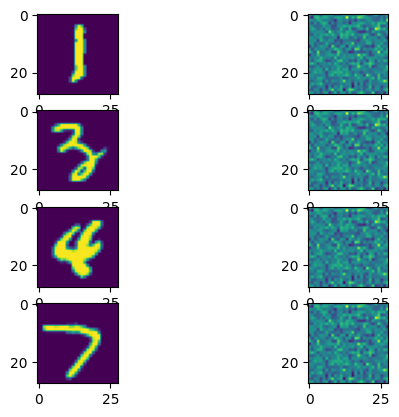

In [53]:
for i in range(4):
    idx = random.randint(1,100)
    
    plt.subplot(4,2,1+2*i)
    plt.imshow(X_test[idx])
    plt.subplot(4,2,2+2*i)

    ae_model.eval()
    with torch.no_grad():
        img = (ae_model(X_test[idx].reshape((1,28,28)).to(torch.float32))).detach().numpy().reshape(28,28)
        plt.imshow(img)

In [54]:
torch.save(ae_model.state_dict(), f'./ae_model/AutoEncoder_model_state_dict_latent=3_epoch={EPOCHs}_{time.time()}.pth')

# DCGANs

- inspired : [Github](https://github.com/Ksuryateja/DCGAN-MNIST-pytorch/blob/master/gan_mnist.py#L182C4-L182C4)

## Generator
- input : `(100,1,1)` random noise for 100 dimension
- output : `(1,28,28)` image of hand writing

## Discriminator
- input : `(1, 28, 28)`
- output : `True or False`

In [55]:
class DCGAN_generator(nn.Module):
    def __init__(self, latent_dim = 100):
        super().__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100,
                               out_channels=1024,
                               kernel_size=4),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=1024,
                               out_channels=512,
                               kernel_size=5),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=512,
                               out_channels=256,
                               kernel_size=9),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=256,
                               out_channels=1,
                               kernel_size=13),
            nn.Sigmoid(),
            
        )

    def forward(self, x_in):
        return self.model(x_in)

    def predict(self, x_pred):
        self.model.eval()
        return self.model(x_pred)

summary(DCGAN_generator(), (100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       1,639,424
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]      13,107,712
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]      10,617,088
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]          43,265
          Sigmoid-11            [-1, 1, 28, 28]               0
Total params: 25,411,073
Trainable params: 25,411,073
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Fo

In [56]:
class DCGAN_discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=32,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=32,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p = 0.25),
            nn.Flatten(),
            nn.LeakyReLU(),
            nn.Linear(9216, 1),
            nn.Sigmoid()
        )

    def forward(self, x_in):
        return self.model(x_in) > 0.5

    def predict(self, x_pred):
        self.model.eval()
        return self.model(x_pred) > 0.5

summary(DCGAN_discriminator(), (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
              ReLU-4           [-1, 64, 24, 24]               0
         MaxPool2d-5           [-1, 64, 12, 12]               0
           Dropout-6           [-1, 64, 12, 12]               0
           Flatten-7                 [-1, 9216]               0
         LeakyReLU-8                 [-1, 9216]               0
            Linear-9                    [-1, 1]           9,217
          Sigmoid-10                    [-1, 1]               0
Total params: 28,033
Trainable params: 28,033
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.17
Params size (MB): 0.11
Estimated Tot

## Train DCGANs models

In [57]:
DCGAN_model_D = DCGAN_discriminator()

DCGAN_model_G = DCGAN_generator()

In [58]:
criterion = nn.BCELoss()

optimizer_D = torch.optim.Adam(DCGAN_model_D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_G = torch.optim.Adam(DCGAN_model_G.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [59]:
EPOCHs = 1 if TRAIN_DCGAN else 0
BATCH_SIZE = 128

DCGAN_model_D.train()
DCGAN_model_G.train()

for epoch in range(EPOCHs):
    for i in range(X_train.shape[0]//BATCH_SIZE):
        # train generator model
        batch_x_train = X_train[BATCH_SIZE*i : BATCH_SIZE*i + BATCH_SIZE].reshape(-1,1,28,28)
        real_label = torch.ones((BATCH_SIZE, 1), dtype=torch.float32, requires_grad=True)
        fake_label = torch.zeros((BATCH_SIZE, 1), dtype=torch.float32, requires_grad=True)
        
        # -------------------------------
        # (1) train Discriminator model
        # -------------------------------
        DCGAN_model_G.eval()
        DCGAN_model_D.train()
        DCGAN_model_D.zero_grad()

        # (1.1) train with real image
        d_pred_real = DCGAN_model_D(batch_x_train).to(torch.float32)
        d_loss_real = criterion(d_pred_real, real_label)
        d_loss_real.backward()

        # (1.2) train with fake image
        noise = torch.randn(BATCH_SIZE, 100, 1, 1)
        fake_x = DCGAN_model_G(noise)
        d_pred_fake = DCGAN_model_D(fake_x).to(torch.float32)
        d_loss_fake = criterion(d_pred_fake, fake_label)
        d_loss_fake.backward()

        optimizer_D.step()

        d_loss = d_loss_real + d_loss_fake

        # -------------------------------
        # (2) train Generator model
        # -------------------------------
        DCGAN_model_G.train()
        DCGAN_model_D.eval()
        DCGAN_model_G.zero_grad()

        g_fake = DCGAN_model_G(noise)
        output = DCGAN_model_D(g_fake).to(torch.float32)
        g_loss = criterion(output, real_label)
        g_loss.backward()

        optimizer_G.step()
        
        # -------------------------------
        # test both model
        # -------------------------------
        DCGAN_model_D.eval()
        DCGAN_model_G.eval()

        with torch.inference_mode():
            pass
        
        print(f'Epoch : {epoch}/{EPOCHs}({i}/{X_train.shape[0]//BATCH_SIZE})', end = '\t|')
        print(f'D loss : {d_loss.item()}', end ='\t|')
        print(f'G loss : {g_loss.item()}', end = '\t|')
        print('')

Epoch : 0/1(0/468)	|D loss : 76.5625	|G loss : 100.0	|
Epoch : 0/1(1/468)	|D loss : 67.96875	|G loss : 100.0	|
Epoch : 0/1(2/468)	|D loss : 65.625	|G loss : 100.0	|
Epoch : 0/1(3/468)	|D loss : 73.4375	|G loss : 100.0	|
Epoch : 0/1(4/468)	|D loss : 79.6875	|G loss : 100.0	|
Epoch : 0/1(5/468)	|D loss : 76.5625	|G loss : 100.0	|
Epoch : 0/1(6/468)	|D loss : 68.75	|G loss : 100.0	|


KeyboardInterrupt: 